In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import numpy as np

df = pd.read_csv('user_info.csv')

print(df.shape)
df = df.drop('username',axis=1)
df['won'] = [0]*df.shape[0]
kd = [i/(1+sum([df.qps_elims,df.qps_deaths])) for i in [df.qps_elims,df.qps_deaths]]
df['kill_ratio'] = kd[0]
df['death_ratio'] = kd[1]
df.head(10)

##get rid of 1 row 1644 / 6 = 274

(1645, 136)


,level,rating,prestige,games_won,qps_elims,qps_dmg_done,qps_deaths,qps_solo_kills,medals_bronze,medals_silver,...,zenyatta_dmg_done,zenyatta_deaths,zenyatta_solo_kills,sigma_elims,sigma_dmg_done,sigma_deaths,sigma_solo_kills,won,kill_ratio,death_ratio
0,37,0,0,53,1186,293243,629,198,69,75,...,2542,4,0,0,0,0,0,0,0.653084,0.346366
1,89,0,0,111,2692,834709,1321,254,173,252,...,797999,876,177,0,0,0,0,0,0.670653,0.329098
2,66,0,11,1687,35409,9100353,23088,6132,2613,2486,...,121520,231,41,0,0,0,0,0,0.605303,0.394680
3,38,0,2,70,1488,8127,1023,312,98,93,...,3558,9,0,0,0,0,0,0,0.592357,0.407245
4,20,0,0,48,1696,562467,605,462,46,62,...,8222,8,0,0,0,0,0,0,0.736751,0.262815
5,19,0,5,525,11170,1889985,6666,2274,815,857,...,48754,82,22,0,0,0,0,0,0.626226,0.373718
6,99,0,6,1931,51482,10044363,21026,8329,2757,3669,...,439256,541,85,0,0,0,0,0,0.710008,0.289978
7,1,0,3,56,1098,131564,836,241,76,93,...,8119,14,5,0,0,0,0,0,0.567442,0.432041
8,65,0,9,1473,37440,9323089,16677,6889,1993,2437,...,252585,341,68,0,0,0,0,0,0.691822,0.308160
9,49,0,0,16,277,82719,144,20,25,32,...,0,0,0,0,0,0,0,0,0.656398,0.341232


In [36]:
def get_team():
    index = [i for i in np.random.randint(0,df.shape[0],size=12)]
    
    team1 = df.iloc[index[0:6]].mean(axis=0)
    team2 = df.iloc[index[6:12]].mean(axis=0)
    
    t1 = 0
    t2 = 0
    for col in df.columns:
        if 'deaths' in col:
            if team1[col] > team2[col]:
                t1 = t1 - 1
                t2 = t2 + 1
            else:
                t1 = t1 + 1
                t2 = t2 - 1
        else:
            if team1[col] > team2[col]:
                t1 = t1 + 1
                t2 = t2 - 1
            else:
                t1 = t1 - 1
                t2 = t2 + 1
    
    if np.random.randint(0,100) >= 90:
        t1 = t1 + 10
    elif np.random.randint(0,100) <= 10:
        t2 = t2 + 10
    
    if t1 > t2:
        team1['won'] = 1
        team2['won'] = 0
    elif t2 > t1:
        team1['won'] = 0
        team2['won'] = 1
    else:
        team1['won'] = 1
        team2['won'] = 1
        
    return pd.DataFrame([team1,team2], columns=df.columns)

team_averages = pd.DataFrame(columns=df.columns)

for i in range(1000):
    team_averages = team_averages.append(get_team())

In [37]:
team_averages.shape

(2000, 138)

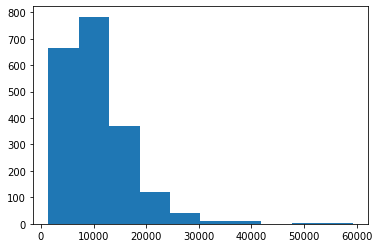

In [38]:
# df.qps_elims.plot(kind='hist', normed=True)

plt.hist(team_averages.qps_elims);

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

y_pred = [1]*len(team_averages)

accuracy_score(team_averages.won,y_pred)
# df.head()

In [40]:
train, test = train_test_split(team_averages, train_size=0.80, test_size=0.20, 
                              stratify=team_averages['won'], random_state=42)

target = 'won'
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
train.shape, test.shape

((1600, 138), (400, 138))

In [41]:
sample_weight = [1]*len(X_train)
for i in range(len(sample_weight)):
    if i in [5,6,7,8]:
        sample_weight[i] *= 15
        
len(sample_weight)

1600

In [47]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1,max_depth=20)

# Fit on train, score on val
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)
print('Accuracy Score', accuracy_score(y_test, rfc_y_pred), ' - Model Score', rfc.score(X_test,y_test))

Accuracy Score 0.71  - Model Score 0.71


In [43]:
# fit model no training data
xgb = XGBClassifier(n_estimators=1000,random_state=42,max_depth=10, n_jobs=-1)

xgb.fit(X_train, y_train, sample_weight = sample_weight)

xgb_y_pred = xgb.predict(X_test)

print('Accuracy Score', accuracy_score(y_test, xgb_y_pred), ' - Model Score', xgb.score(X_test,y_test))

Accuracy Score 0.665  - Model Score 0.665


In [44]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=25, leaf_size=30,weights='distance')
knc.fit(X_train, y_train) 

knc_y_pred = knc.predict(X_test)

print('Accuracy Score', accuracy_score(y_test, knc_y_pred), ' - Model Score', knc.score(X_test,y_test))

Accuracy Score 0.7125  - Model Score 0.7125


In [45]:
from sklearn import svm

clf = svm.SVC(gamma=1)
clf.fit(X_train, y_train, sample_weight=sample_weight)

clf_y_pred = clf.predict(X_test)

print('Accuracy Score', accuracy_score(y_test, clf_y_pred), ' - Model Score', clf.score(X_test,y_test))

Accuracy Score 0.505  - Model Score 0.505


## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Choose which features, if any, to exclude. Would some features "leak" information from the future?

### Target: Win or lose rate
### I will train on individual players based on their past games and heroes. 